In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [48]:
!source 

zsh:source:1: not enough arguments


In [49]:
df = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')


# q1. Read the data for January. How many columns are there?
len(df. columns)




19

In [50]:
df.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN
2463930,2,2022-01-31 23:46:00,2022-02-01 00:13:00,NaN,8.94,NaN,None,186,181,0,25.48,0.0,0.5,6.28,0.0,0.3,35.06,NaN,NaN


In [51]:
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

"""
q2. compute the duration variable. It should contain the duration of a ride in minutes.
What's the standard deviation of the trips duration in January?
""" 
df.duration.std()

46.44530513776499

In [52]:
# axs[0].hist(dist1, bins=n_bins)
# sns.displot(df.duration)

In [53]:
# q.3: Fraction of the records left after dropping the outliers
((df.duration >= 1) & (df.duration <= 60)).sum() / len(df)

0.9827547930522406

In [54]:
# drop outiliers
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [56]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [57]:
train_dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [58]:
# q.4. Dimensionality after OHE
X_train.shape

(2421440, 515)

In [59]:
# q.5: RMSE on train

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

6.986190135970212

/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


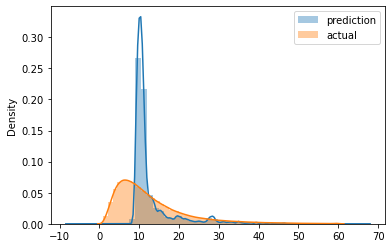

In [60]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()


In [61]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    # df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    # df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')



In [63]:
df_train[categorical]

,PULocationID,DOLocationID
0,142,236
1,236,42
2,166,166
3,114,68
4,68,163
...,...,...
2463926,90,170
2463927,107,75
2463928,113,246
2463929,148,164


In [65]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [66]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [67]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)


In [68]:
# q.6: RMSE on validation
mean_squared_error(y_val, y_pred, squared=False)

# Note: follow up on results

5.41512002191379

/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


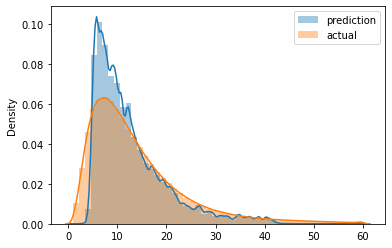

In [69]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()
